# Dataset exploration and analysis


### Imports

In [2]:
import os

import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt

from collections import Counter

from typing import List, Set, Dict, Tuple, Optional, Set, Iterable

from IPython.display import display


In [3]:
#@title Configuration
IS_COLAB = False # @param { type: "boolean" }
DS_PATH = "../language-modeling/penn_treebank" #@param { type: "string" }

### Colab setup

In [3]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

### Dataset preparation

In [3]:
# Get the dataset
!wget -o log --show-progress --progress=bar https://data.deepai.org/ptbdataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!rm -rf $DS_PATH
!mkdir -p $DS_PATH
!unzip -d $DS_PATH ptbdataset.zip


Archive:  ptbdataset.zip
  inflating: penn_treebank/README    
  inflating: penn_treebank/ptb.char.test.txt  
  inflating: penn_treebank/ptb.char.train.txt  
  inflating: penn_treebank/ptb.char.valid.txt  
  inflating: penn_treebank/ptb.test.txt  
  inflating: penn_treebank/ptb.train.txt  
  inflating: penn_treebank/ptb.valid.txt  


In [4]:
ptb_train_path = "ptb.train.txt"
ptb_test_path = "ptb.test.txt"
ptb_valid_path = "ptb.valid.txt"

# Dataset exploration

## Utilities

In [5]:
def get_sents_from_file(file_name: str) -> List[str]:
  sents: List[str] = []
  with open(f'{DS_PATH}/{file_name}') as file:
    for sent in file:
      sents.append(sent)
  return sents

In [6]:
def get_words_from_sents(sents: List[str]) -> List[str]:
  words: List[str] = []
  for sent in sents:
    words.extend(sent.split())
  return words 

In [7]:
def get_vocab(words: List[str]) -> Set[str]:
  '''
  Penn Treebank is already lowercased
  '''
  return set(words)

In [8]:
def compute_set_difference(a: Set, b: Set) -> Set:
    return a - b

In [9]:
def compute_set_intersection(a: Set, b: Set) -> Set:
    return a.intersection(b)

In [10]:
def plot_stats(
        sents: List[List[str]], 
        words: List[List[str]], 
        vocabs: List[List[str]]) -> None:

    splits = ['train', 'test', 'valid']
    cols = ['sentences', 'words', 'vocab size']

    data = {col: [len(l) for l in split] for col, split in zip(cols, [sents, words, vocabs])}

    table = pd.DataFrame(data, index = splits)
    display(table)

In [11]:
def plot_split_percentage(
        sents: List[List[str]], 
        words: List[List[str]]) -> None:

    splits = ['train', 'test', 'valid']
    cols = ['sentences', 'words', 'vocab size']


    sents_tot = sum([len(l) for l in sents])
    words_tot = sum([len(l) for l in words])
    sents_perc = [len(l) / sents_tot for l in sents]
    words_perc = [len(l) / words_tot for l in words]

    fig, axs = plt.subplots(1, 2)
    for idx, (col, data) in enumerate(zip(cols, [sents_perc, words_perc])):
        axs[idx].set_title(f'{col} split percentage')
        axs[idx].pie(
            data, 
            labels = splits, 
            autopct = '%1.1f%%',
            shadow = True, 
            startangle = 90,
            )

    plt.show()

In [12]:
def print_oov_words(vocabs: Iterable, train_vocab: Set[str]) -> None:
    oov_words_list = []
    for vocab in vocabs:
        oov_words_list.append(compute_set_difference(vocab, train_vocab))
    names = ['test oov words', 'valid oov words']
    data = {name: [len(oovs)] for (name, oovs) in zip(names, oov_words_list)}
    table = pd.DataFrame(data, index=['size'])
    display(table)

## Dataset statistics

In [13]:
sents_train = get_sents_from_file(ptb_train_path)
sents_test = get_sents_from_file(ptb_test_path)
sents_valid = get_sents_from_file(ptb_valid_path)

words_train = get_words_from_sents(sents_train)
words_test = get_words_from_sents(sents_test)
words_valid = get_words_from_sents(sents_valid)

vocab_train = get_vocab(words_train)
vocab_test = get_vocab(words_test)
vocab_valid = get_vocab(words_valid)

In [78]:
sents_train[:20]

[' aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter \n',
 ' pierre <unk> N years old will join the board as a nonexecutive director nov. N \n',
 ' mr. <unk> is chairman of <unk> n.v. the dutch publishing group \n',
 ' rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate \n',
 ' a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported \n',
 ' the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said \n',
 ' <unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <unk> in its <unk> cigarette filters in

In [14]:
plot_stats(
    [sents_train, sents_test, sents_valid],
    [words_train, words_test, words_valid],
    [vocab_train, vocab_test, vocab_valid],
)

,sentences,words,vocab size
train,42068,887521,9999
test,3761,78669,6048
valid,3370,70390,6021


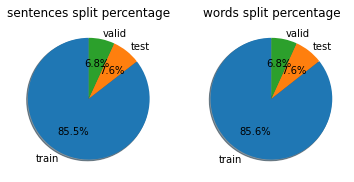

In [15]:
plot_split_percentage(
    [sents_train, sents_test, sents_valid],
    [words_train, words_test, words_valid]
)

## OOV words

In [16]:
print_oov_words([vocab_test, vocab_valid], vocab_train)

,test oov words,valid oov words
size,0,0


## Words frequency

In [74]:
def compute_word_frequencies(words: Set[str]) -> Dict[str, int]:
    counts = Counter(words)
    return counts

def reverse_sort_frequency_counter(counts: Counter, cutoff: int = 0) -> Dict[str, int]:
    truncate = len(counts) - cutoff
    return dict(sorted(dict(counts).items(), key=lambda item: item[1], reverse=True)[:cutoff])

def plot_word_stats(words: Set[str], split_name: str, cutoff: int = 10) -> None:
    counts = compute_word_frequencies(words)
    counts = reverse_sort_frequency_counter(counts, cutoff)
    
    keys = list(counts.keys())
    vals = list(counts.values())

    sum_counts_frequencies = sum(vals)


    plt.rcdefaults()
    fig, axs = plt.subplots(1,2, figsize=(21,7))
    y_pos = np.arange(len(keys))

    axs[0].barh(y_pos, vals,  align='center')
    axs[0].set_yticks(y_pos, labels=keys)
    axs[0].invert_yaxis()  # labels read top-to-bottom
    axs[0].set_xlabel('Occurrencies')
    axs[0].set_title(f'{split_name} 10 most frequent words')

    keys.append("Others")
    vals.append(len(words) - sum_counts_frequencies)

    theme = plt.get_cmap('bwr')
    axs[1].set_prop_cycle("color", [theme(1. * i / len(keys))
                             for i in range(len(keys))])
    axs[1].set_title("Percentage")
    axs[1].pie(
        [v / len(words) for v in vals], 
        labels = keys, 
        autopct = '%1.1f%%',
        shadow = True, 
        startangle = 90,
        radius=1.
        )

    plt.show()

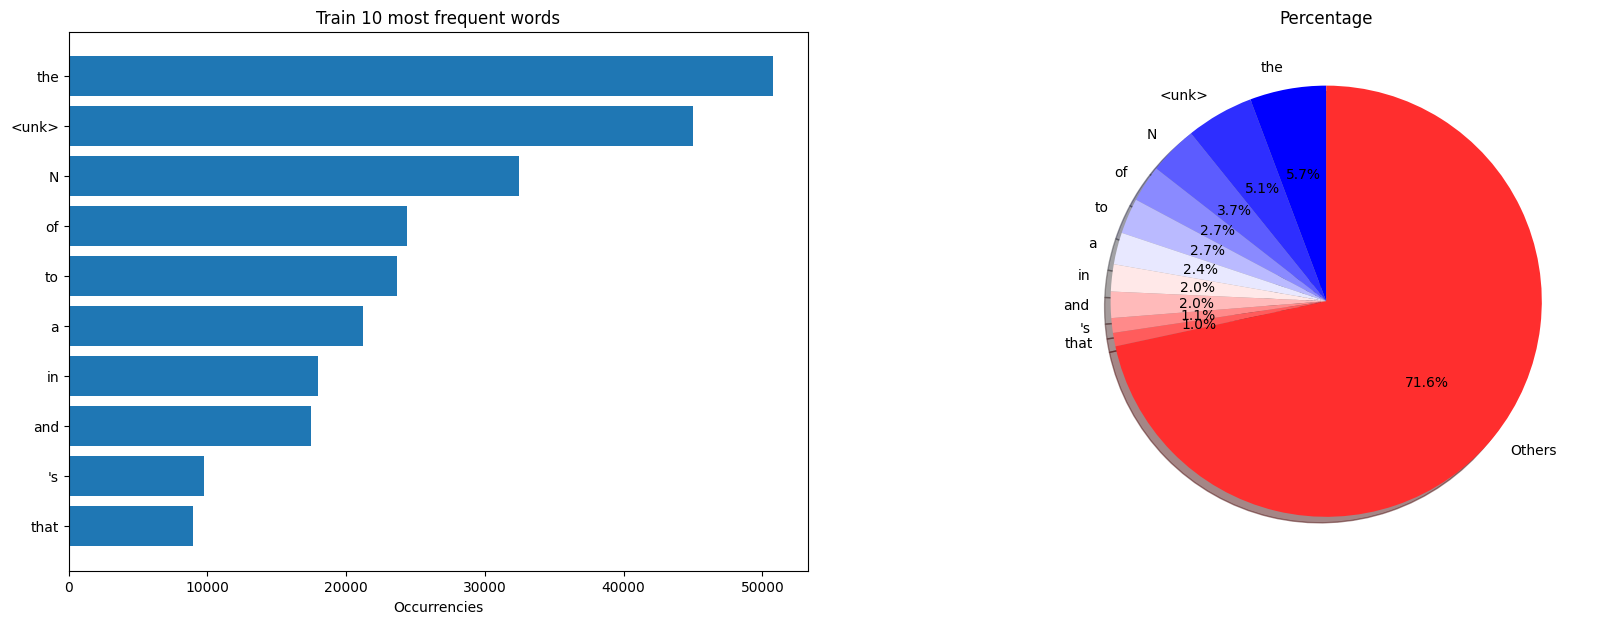

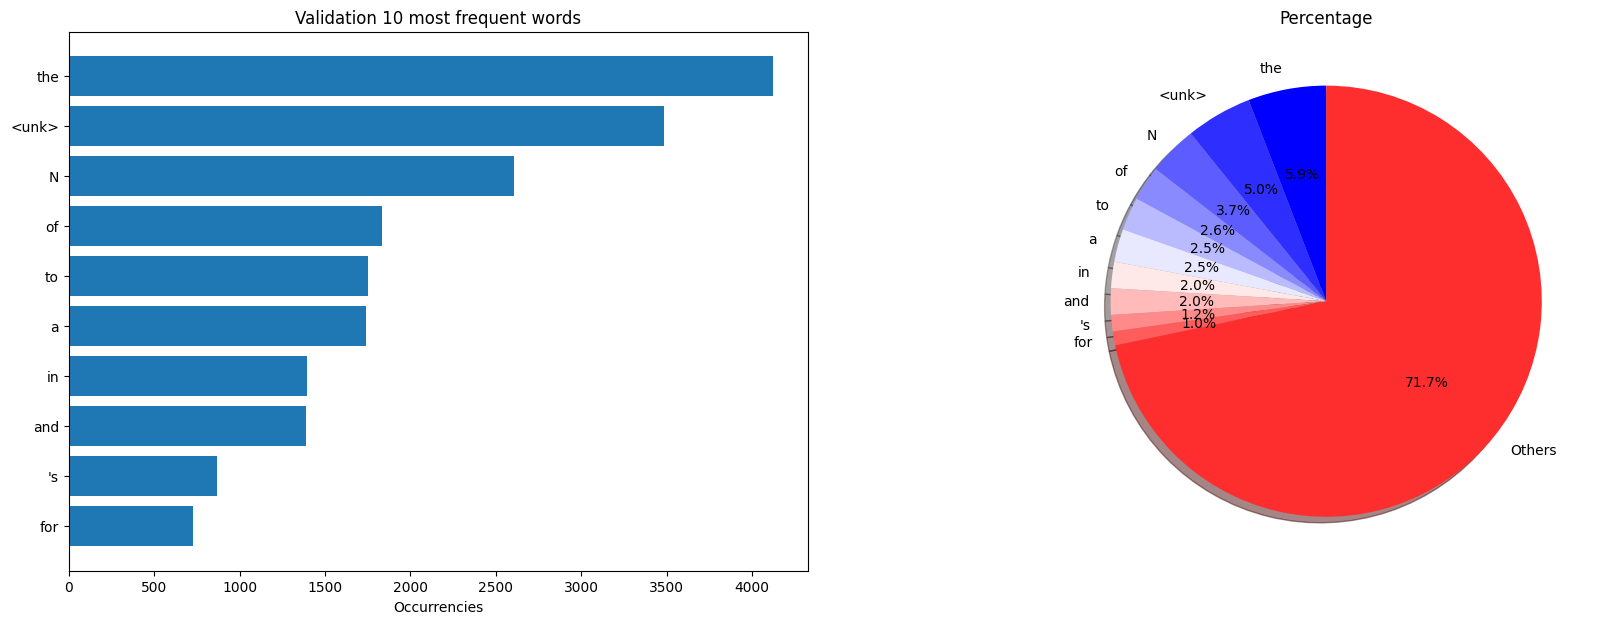

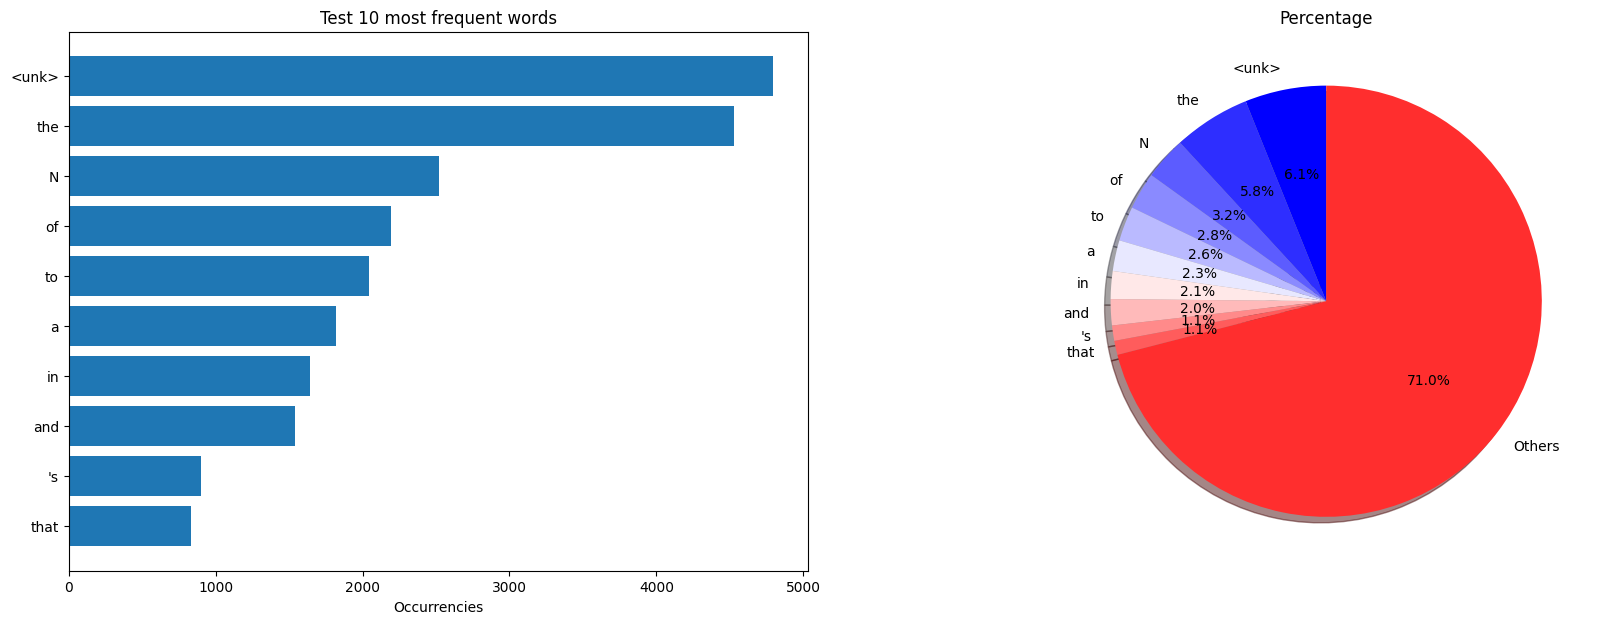

In [77]:
plot_word_stats(words_train, "Train")
plot_word_stats(words_valid, "Validation")
plot_word_stats(words_test, "Test")